In [1]:
import numpy as np
from utils.model_3d_denseunet import threed_unet
from utils.model_1 import get_model
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
MRI_nii_folder_path = 'nii_save_np/lacune/'
cv = 3
# S1------------------------------------------
train_val_path1 = np.load(MRI_nii_folder_path+f'cv{cv}_path_train_val.npy')
train_val_x1 = np.load(MRI_nii_folder_path+f'cv{cv}_x_strain_val.npy')
train_val_y1 = np.load(MRI_nii_folder_path+f'cv{cv}_y_strain_val.npy')

print(train_val_x1.shape, train_val_y1.shape, train_val_path1.shape)
# S2------------------------------------------
train_val_x2 = np.load(MRI_nii_folder_path+f'cv{cv}_x_ctrain_val.npy')
train_val_y2 = np.load(MRI_nii_folder_path+f'cv{cv}_y_ctrain_val.npy')
print(train_val_x2.shape, train_val_y2.shape, train_val_path1.shape)

(129, 32, 192, 192) (129, 32, 192, 192) (129,)
(129, 32, 192, 192) (129,) (129,)


In [2]:
ds = int(train_val_x1.shape[0]*0.8)
x_val1 = train_val_x1[ds:].astype(np.float32)
y_val1 = train_val_y1[ds:].astype(np.float32)
valid_path1 = train_val_path1[ds:]
x_val2 = train_val_x2[ds:].astype(np.float32)
y_val2 = train_val_y2[ds:].astype(np.float32)
valid_path2 = train_val_path1[ds:]
print(x_val1.shape, y_val1.shape)
print(x_val2.shape, y_val2.shape)

(26, 32, 192, 192) (26, 32, 192, 192)
(26, 32, 192, 192) (26,)


In [3]:
weight_name1 = f'pair_L_154_3DUnet_binary_batch-1_focal_tversky_leaky_aug_Adam-lr-1e-5_cv{cv}_t4.hdf5'
weight_name2 = f'154_lacune_batch-4_wce_relu_aug_Adam-lr_1e-5_cv{cv}_t1_cw.h5'
weight_path1 = '3d_mask_classification/checkpoint/2_class/binary1/' + weight_name1
weight_path2 = 'chekpoint/lacune/' + weight_name2
print(weight_path1)
print(weight_path2)

3d_mask_classification/checkpoint/2_class/binary1/pair_L_154_3DUnet_binary_batch-1_focal_tversky_leaky_aug_Adam-lr-1e-5_cv3_t4.hdf5
chekpoint/lacune/154_lacune_batch-4_wce_relu_aug_Adam-lr_1e-5_cv3_t1_cw.h5


In [4]:
# S1------------------------------------------
print('-'*30)
print('Loading S1 saved weights...')
print('-'*30)
model1 = threed_unet(img_depth=32, img_rows=192, img_cols=192)
model1.load_weights(weight_path1)
Results = model1.predict(x_val1, batch_size=5, verbose=1)

------------------------------
Loading S1 saved weights...
------------------------------
6/6 [==============================] - 101s 17s/step


In [5]:
print(Results.shape)
Results1 = np.squeeze(Results)
print(Results1.shape)

(26, 32, 192, 192, 1)
(26, 32, 192, 192)


In [7]:
Stage1_Result = (np.squeeze(Results1)>0.10).astype(np.int32)
print(Stage1_Result.shape)
print(x_val1.shape)

(26, 32, 192, 192)
(26, 32, 192, 192)


In [8]:
# Classification
from tqdm import tqdm
image_mask = np.zeros((x_val1.shape[0],32,192,192))

def mask_stroke_area(image_, mask_):
    image_save = image_.copy()
    for i in range(image_.shape[0]):
        for j in range(image_.shape[1]):
            for k in range(image_.shape[2]):
                if mask_[i][j][k]==0:
                    image_save[i][j][k]=0
    return image_save

# for i in tqdm(range(cost)):
for i in tqdm(range(x_val1.shape[0])):
    image_mask[i] = mask_stroke_area(x_val1[i],Stage1_Result[i])

100%|██████████| 26/26 [01:34<00:00,  3.62s/it]


In [9]:
print(image_mask.shape)

(26, 32, 192, 192)


In [11]:
# S2------------------------------------------
print('-'*30)
print('Loading S2 saved weights...')
print('-'*30)
model2 = get_model(depth=32, width=192, height=192, class_num=1)
model2.load_weights(weight_path2)

------------------------------
Loading S2 saved weights...
------------------------------
(None, 30, 95, 95, 64)
(None, 14, 46, 93, 64)
(None, 6, 22, 91, 128)
(None, 2, 10, 89, 256)


In [12]:
Results2 = model2.predict(image_mask, batch_size=1, verbose=1)

26/26 [==============================] - 17s 655ms/step


In [21]:
import pandas as pd
argmax_pred = np.reshape((Results2>0.1).astype(int),(len(Results2)))
argmax_truth = y_val2.astype(int)
Pred_dict ={}
Trut_dict ={}
nii_data=[]
count = 0
for i in valid_path1:
    nii_data.append(i[-14:-8])

result_df = {'nii name':nii_data,
             'Prediction': argmax_pred,
             'GroundTruth':argmax_truth
            }
results_df = pd.DataFrame(result_df)
print('|0 = Lacune |  | 1 = Non-Lacune|\n')
print(results_df)

|0 = Lacune |  | 1 = Non-Lacune|

   nii name  Prediction  GroundTruth
0    is0136           0            1
1    is0125           0            1
2    is0132           1            1
3    is0038           1            1
4    is0067           1            1
5    is0074           1            1
6    is0001           1            1
7    is0031           1            1
8    is0008           1            1
9    is0082           1            1
10   is0127           0            1
11   is0029           0            0
12   is0072           0            0
13   is0056           0            0
14   is0083           0            0
15   is0040           0            0
16   is0071           0            0
17   is0145           0            0
18   is0021           0            0
19   is0077           1            0
20   is0039           0            0
21   is0041           0            0
22   is0004           0            0
23   is0111           1            0
24   is0007           0            0
25  

In [22]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
cm = confusion_matrix(argmax_truth, argmax_pred)
np.set_printoptions(precision=2)

In [23]:
import itertools
import matplotlib.pyplot as plt
imgs_test = x_val2
imgs_mask_test = y_val2
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=20)
    
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)
    plt.tight_layout()

Normalized confusion matrix
[[13  2]
 [ 3  8]]


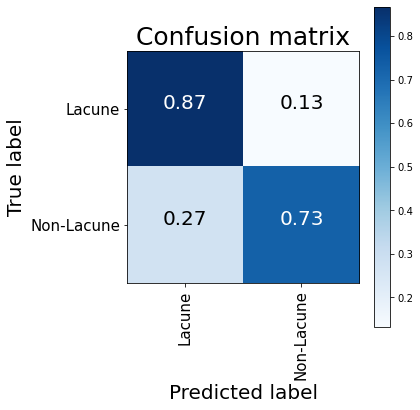

In [24]:
# species =['Normal','Anterior','Posterior']
species = ['Lacune', 'Non-Lacune']
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, species)
print(cm)